In [301]:
import json
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity 

In [302]:
# reading data from json file
f = open(r'C:\Users\Nadeem\Desktop\BSDS\Semester 5\Data Visualization and Analysis\DVA Project\data+scriptssss.json', encoding="utf8")
data = json.load(f)
f.close()

In [303]:
# converting dictionary into dataframe
df = pd.DataFrame(data["movies"])
df.head()

,name,year,running time,genre,script
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,THE EMPIRE STRIKES BACK\n\n\n\t\t\t\t Written ...
1,9 to 5,1980,1 hr 49 min,Comedy,Nine To Five Script\n\n \n\n ...
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,Who needs Hollywood?\nI hear they're\nreally n...
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,"""RAIDERS OF TH..."
4,On Golden Pond,1981,1 hr 49 min,Drama,Norman!\nCome here. Come here.\n\n \n ...


# Data Cleaning
The Data is the script of movies, all the scripts are lower cased, the symbols, line breaks are removed. The data is lemmatized because we need the context of the words.

In [304]:
#nlp = spacy.load('en_core_web_sm')
import nltk
from nltk.stem import WordNetLemmatizer
def clean_string(text):

    final_string = ""

    # Make lower
    text = text.lower()

    # Remove line breaks
    text = re.sub(r'\n', ' ', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    # Remove stop words
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']

    text_filtered = [word for word in text if not word in useless_words]

    # Remove numbers
    text_filtered = [re.sub(r'\w*\d\w*', '', w) for w in text_filtered]
    
    wnl = WordNetLemmatizer()
    
    text_lemmed = [wnl.lemmatize(word) for word in text]

    text_lemmed = text_filtered

    final_string = ' '.join(text_lemmed)

    return final_string

In [305]:
df["script"] = [clean_string(script) for script in df["script"]]

In [306]:
df.head()

,name,year,running time,genre,script
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,empire strikes back written lawrence kasdan le...
1,9 to 5,1980,1 hr 49 min,Comedy,nine five script shes never worked life though...
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,needs hollywood hear theyre really nuts give t...
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,raiders lost ark screenplay lawrence kasdan st...
4,On Golden Pond,1981,1 hr 49 min,Drama,norman come come norman hurry loons loons they...


# Classification
We first make TFIDF matrix of the scripts and then compute it's similarity distance. Then we use this data to apply hierarchical clustering on our scripts to identify the basic plots of storytelling. We visualize that clustering using the dendograms.

In [307]:
pipe = Pipeline([('counter_vectorizer', CountVectorizer(max_df=0.8, max_features=200000,
    min_df=0.2, stop_words='english',ngram_range=(1,3))),('tfidf_transform', TfidfTransformer())])

tfidf_matrix = pipe.fit_transform([x for x in df['script']])

In [308]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

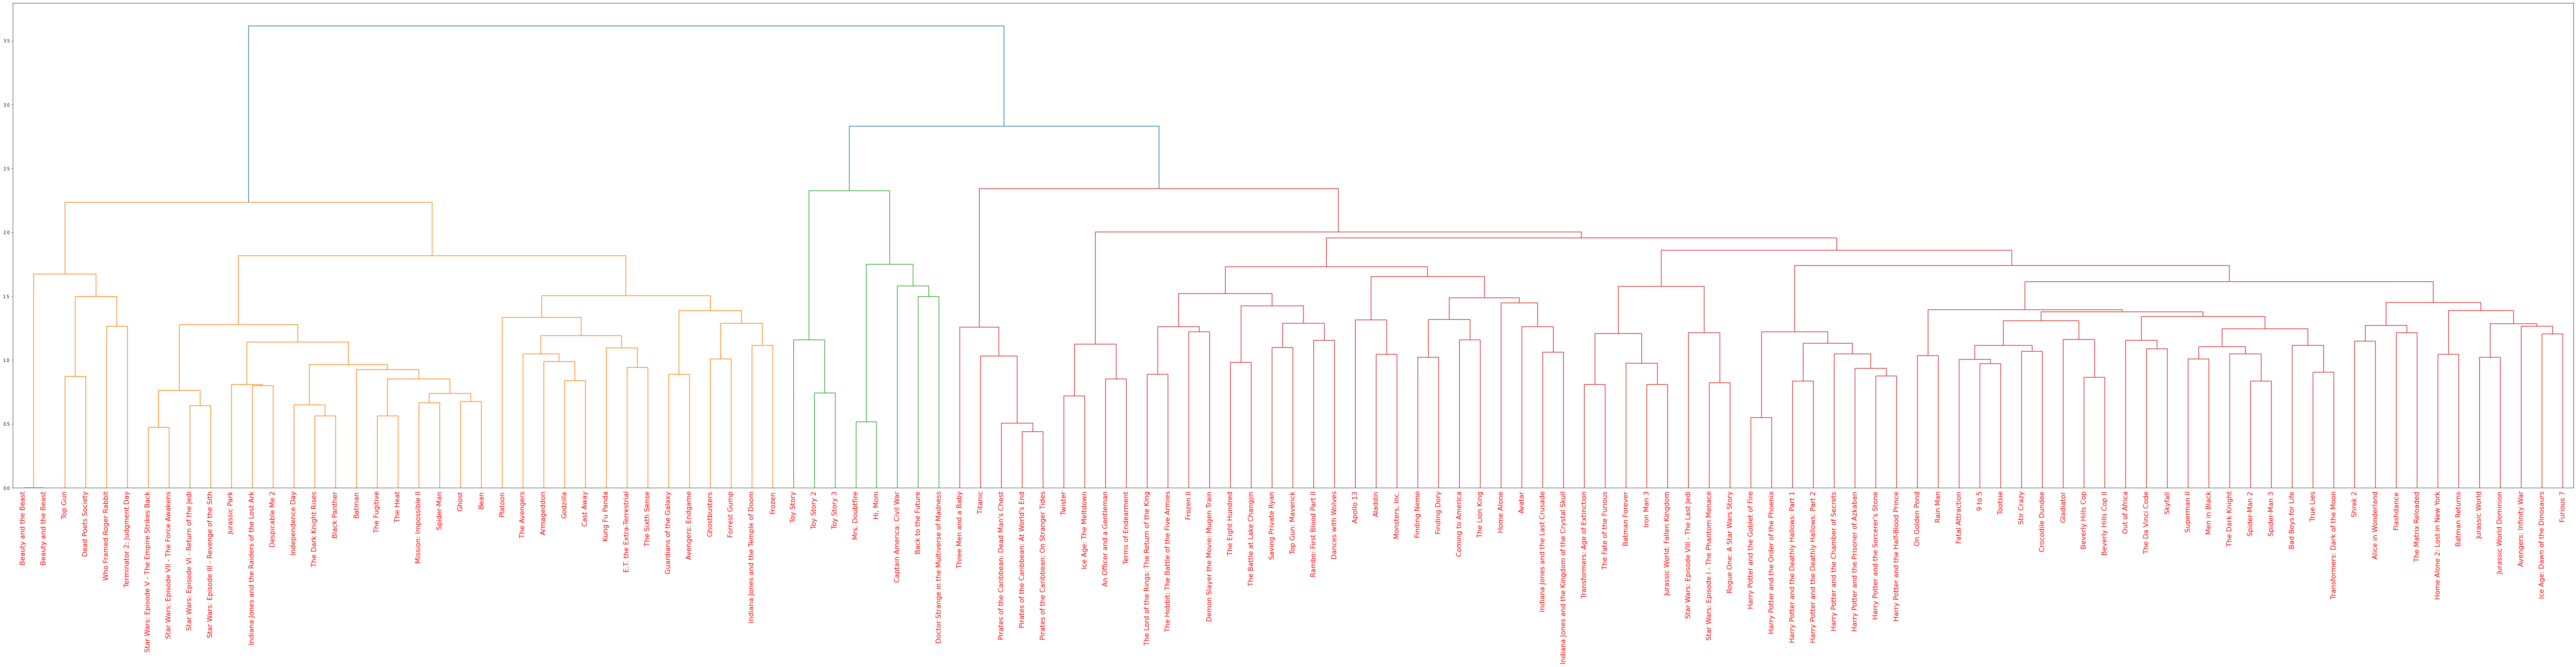

In [309]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

mergings = linkage(similarity_distance, method='complete')
dendrogram_ = dendrogram(mergings, labels=[x for x in df["name"]], leaf_rotation=90,leaf_font_size=16)

fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

plt.show() # check the number of clusters forming (should be 5 to 6)

# Similar movie finder
This model works by using the basic formula of cosine similarity. I have computed similarity distance using the TFIDF Vectors of the scripts and used them to identify the most similar movie out of the dataset we have.

In [310]:
import numpy as np
def find_similar(title):
    index = df[df["name"] == title].index[0]
    vector = similarity_distance[int(index),:]
    most_similar = df.iloc[np.argsort(vector)[1], 0]
    return most_similar

print(find_similar('Avengers: Endgame')) #Indiana Jones and the Kingdom of the Crystal Skull

Guardians of the Galaxy


# Clustering

In [311]:
# categorize the data based on similarity of their plots
from sklearn.feature_extraction.text import TfidfVectorizer
def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(text)
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many clusters do you want to use?')
    true_k = int(input())
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
        
    return clusters

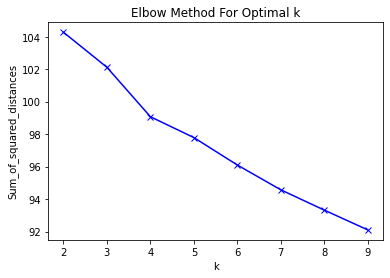

How many clusters do you want to use?
5


In [312]:
plots = cluster_text(df['script'])

In [313]:
plots.head()

,title,cluster
0,empire strikes back written lawrence kasdan le...,4
1,nine five script shes never worked life though...,2
2,needs hollywood hear theyre really nuts give t...,2
3,raiders lost ark screenplay lawrence kasdan st...,1
4,norman come come norman hurry loons loons they...,2


In [314]:
clusters = plots["cluster"].to_list()
df["cluster"] = clusters
df.head()

,name,year,running time,genre,script,cluster
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,empire strikes back written lawrence kasdan le...,4
1,9 to 5,1980,1 hr 49 min,Comedy,nine five script shes never worked life though...,2
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,needs hollywood hear theyre really nuts give t...,2
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,raiders lost ark screenplay lawrence kasdan st...,1
4,On Golden Pond,1981,1 hr 49 min,Drama,norman come come norman hurry loons loons they...,2


In [316]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [317]:
cv = CountVectorizer()
word_count_vector = cv.fit_transform(df["script"])
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [318]:
def extract_keywords(doc,n):
    feature_names=cv.get_feature_names()

    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n
    keywords=extract_topn_from_vector(feature_names,sorted_items,n)

    # now print the results
    for k in keywords:
        print(k,keywords[k])
    
    return

In [319]:
count = 1
for i in df["script"]:
    print("                         Movie:",count)
    extract_keywords(i,10)
    count = count + 1

                         Movie: 1
luke 0.463
han 0.441
leia 0.345
lando 0.23
threepio 0.225
chewie 0.216
falcon 0.198
vader 0.193
artoo 0.155
millennium 0.127
                         Movie: 2
hart 0.54
violet 0.405
judy 0.263
canâ 0.256
doralee 0.183
dont 0.131
get 0.121
roz 0.119
well 0.106
gonna 0.104
                         Movie: 3
rodeo 0.278
dont 0.22
get 0.21
bull 0.205
donahue 0.19
warden 0.168
thats 0.153
skip 0.149
right 0.14
harry 0.123
                         Movie: 4
indy 0.827
marion 0.325
belloq 0.181
shliemann 0.15
sallah 0.129
ark 0.107
indys 0.101
satipo 0.085
belzig 0.079
nazis 0.078
                         Movie: 5
norman 0.77
chelsea 0.189
oh 0.177
ethel 0.162
billy 0.131
chels 0.109
thayer 0.102
dont 0.101
know 0.098
well 0.091
                         Movie: 6
lois 0.491
superman 0.427
lex 0.241
clark 0.234
luthor 0.195
zod 0.164
houston 0.129
know 0.128
jorel 0.125
dont 0.122
                         Movie: 7
elliott 0.714
et 0.514
elliotts 0.218
gertie 0.17

# Analyzing the scripts classified plot-wise

In [315]:
# separating the 6 clusters into dataframes
plot0 = df[df["cluster"] == 0]
plot1 = df[df["cluster"] == 1]
plot2 = df[df["cluster"] == 2]
plot3 = df[df["cluster"] == 3]
plot4 = df[df["cluster"] == 4]

In [320]:
plot0 # rags to riches/Oedipus(fall-rise-fall)

,name,year,running time,genre,script,cluster
46,Batman Forever,1995,2 hr 1 min,Action Adventure,whirring persuade take sandwich sir ill get dr...,0
56,Star Wars: Episode I - The Phantom Menace,1999,2 hr 16 min,Action Adventure Fantasy Sci-Fi,fox fanfare theme music playing engines roarin...,0
92,The Avengers,2012,2 hr 23 min,Action Adventure Sci-Fi,avengers written joss whedon came day day unli...,0
96,Iron Man 3,2013,2 hr 10 min,Action Adventure Sci-Fi,tony famous man said create demons said even m...,0
98,Transformers: Age of Extinction,2014,2 hr 45 min,Action Adventure Sci-Fi,chirping squeals screeching wailing distance s...,0
112,Jurassic World: Fallen Kingdom,2018,2 hr 8 min,Action Adventure Sci-Fi,thudding sonar pinging pinging continues gates...,0
113,Avengers: Endgame,2019,3 hr 1 min,Action Adventure Drama Sci-Fi,close housearrest ankle bracelet clint barton ...,0


In [321]:
plot1 #voyage and return

,name,year,running time,genre,script,cluster
3,Indiana Jones and the Raiders of the Lost Ark,1981,1 hr 55 min,Action Adventure,raiders lost ark screenplay lawrence kasdan st...,1
6,E.T. the Extra-Terrestrial,1982,1 hr 55 min,Adventure Family Sci-Fi,et extraterrestrial melissa mathison commenta...,1
13,Ghostbusters,1984,1 hr 45 min,Action Comedy Fantasy Sci-Fi,real ghostbusters poultrygeist duane capizzi s...,1
14,Indiana Jones and the Temple of Doom,1984,1 hr 58 min,Action Adventure,indiana jones temple doom screenplay gloria ka...,1
16,Back to the Future,1985,1 hr 56 min,Adventure Comedy Sci-Fi,back future writers robert zemeckis bob gale g...,1
18,Top Gun,1986,1 hr 50 min,Action Drama,top gun chip proser revised april registered...,1
20,Platoon,1986,2 hr,Drama War,platoon fade quotation black screen rejoice yo...,1
21,Three Men and a Baby,1987,1 hr 42 min,Comedy Drama Family,three men baby written coline serreau james or...,1
24,Who Framed Roger Rabbit,1988,1 hr 44 min,Adventure Animation Comedy Crime Family Fantas...,shot roger rabbit working title written jeffre...,1
27,Batman,1989,2 hr 6 min,Action Adventure,batman screenplay sam hamm based character cre...,1


In [322]:
plot2 # comedy(crime and drama):man in a hole(fall-rise)

,name,year,running time,genre,script,cluster
1,9 to 5,1980,1 hr 49 min,Comedy,nine five script shes never worked life though...,2
2,Stir Crazy,1980,1 hr 51 min,Comedy Crime,needs hollywood hear theyre really nuts give t...,2
4,On Golden Pond,1981,1 hr 49 min,Drama,norman come come norman hurry loons loons they...,2
5,Superman II,1981,2 hr 7 min,Action Adventure Sci-Fi,ill get door yeah thanks sorry yeah thanks lot...,2
7,Tootsie,1982,1 hr 56 min,Comedy Drama Romance,tootsie script thats right come dont stop keep...,2
8,An Officer and a Gentleman,1982,2 hr 4 min,Drama Romance,officer gentleman script passengers arriving p...,2
10,Terms of Endearment,1983,2 hr 12 min,Comedy Drama,terms endearment script let go minute youre go...,2
11,Flashdance,1983,1 hr 35 min,Drama Music Romance,flashdance script first theres nothing slow gl...,2
12,Beverly Hills Cop,1984,1 hr 45 min,Action Comedy Crime Thriller,truck looks great must fortune know front ok f...,2
15,Out of Africa,1985,2 hr 41 min,Biography Drama Romance,africa script even took gramophone safari thre...,2


In [323]:
plot3 # overcoming the monster

,name,year,running time,genre,script,cluster
43,True Lies,1994,2 hr 21 min,Action Comedy Thriller,honey home roger copy boathouse right time fai...,3
53,Armageddon,1998,2 hr 31 min,Action Adventure Sci-Fi Thriller,armageddon fade blackness hint green becomes e...,3
62,Harry Potter and the Sorcerer's Stone,2001,2 hr 32 min,Adventure Family Fantasy,cat meows shouldve known would professor mcgon...,3
64,Harry Potter and the Chamber of Secrets,2002,2 hr 41 min,Adventure Family Fantasy Mystery,harry potter chamber secret cant let hedwig al...,3
70,Harry Potter and the Prisoner of Azkaban,2004,2 hr 22 min,Adventure Family Fantasy Mystery,boy lumos maxima lumos maxima tollet flushes h...,3
72,Harry Potter and the Goblet of Fire,2005,2 hr 37 min,Adventure Family Fantasy Mystery,dont know hot today isnt going get even worse ...,3
78,Harry Potter and the Order of the Phoenix,2007,2 hr 18 min,Action Adventure Family Fantasy Mystery,weatherman radio dont know hot today isnt goin...,3
84,Harry Potter and the Half-Blood Prince,2009,2 hr 33 min,Action Adventure Family Fantasy Mystery,killed sirius black hes back police continuing...,3
88,Harry Potter and the Deathly Hallows: Part 1,2010,2 hr 26 min,Adventure Family Fantasy Mystery,dark times denying world perhaps faced greater...,3
89,Harry Potter and the Deathly Hallows: Part 2,2011,2 hr 10 min,Adventure Fantasy Mystery,beautiful aunts used come kids order uses safe...,3


In [324]:
plot4 #the quest

,name,year,running time,genre,script,cluster
0,Star Wars: Episode V - The Empire Strikes Back,1980,2 hr 4 min,Action Adventure Fantasy Sci-Fi,empire strikes back written lawrence kasdan le...,4
9,Star Wars: Episode VI - Return of the Jedi,1983,2 hr 11 min,Action Adventure Fantasy Sci-Fi,return jedi lawrence kasdan george lucas novel...,4
73,Star Wars: Episode III - Revenge of the Sith,2005,2 hr 20 min,Action Adventure Fantasy Sci-Fi,star wars episode revenge sith script george ...,4
101,Star Wars: Episode VII - The Force Awakens,2015,2 hr 18 min,Action Adventure Sci-Fi,star wars force awakens written lawrence kasda...,4
107,Star Wars: Episode VIII - The Last Jedi,2017,2 hr 32 min,Action Adventure Fantasy Sci-Fi,clear yet theres still pallets cannon shells ...,4


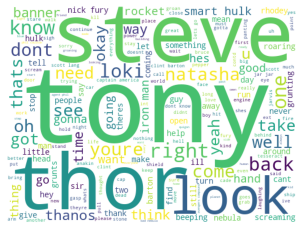

In [337]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot0['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

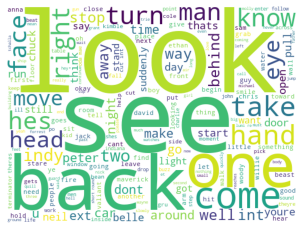

In [326]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot1['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

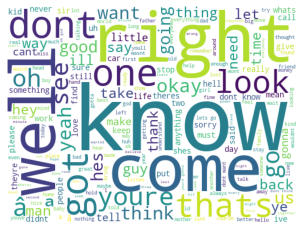

In [327]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot2['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

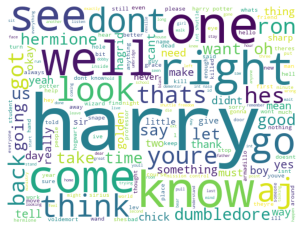

In [336]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot3['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

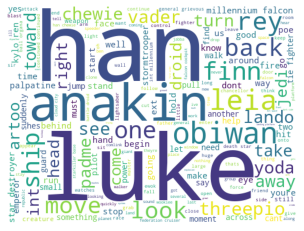

In [328]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(plot4['script']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

# Analyzing the scripts decade-wise

In [329]:
eighties = df.query('year >= 1980 & year <= 1989')
ninties = df.query('year >= 1990 & year <= 1999')
hundreds = df.query('year >= 2000 & year <= 2009')
tens  = df.query('year >= 2010 & year <= 2019')
twenties = df.query('year >= 2020 & year <= 2022')

In [330]:
from wordcloud import WordCloud

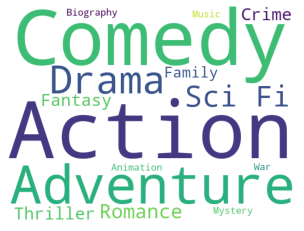

In [342]:
wordcloud = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(eighties['genre']))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

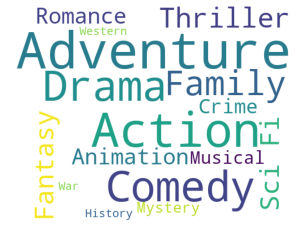

In [341]:
wordcloud2 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(ninties['genre']))
plt.imshow(wordcloud2) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

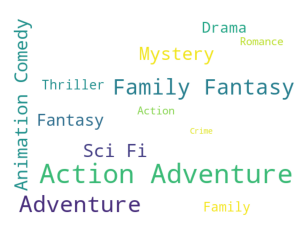

In [340]:
wordcloud3 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(hundreds['genre']))
plt.imshow(wordcloud3) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

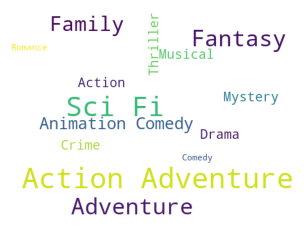

In [338]:
wordcloud4 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(tens['genre']))
plt.imshow(wordcloud4) # image show
plt.axis('off') # to off the axis of x and y
plt.show()

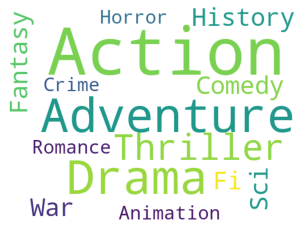

In [339]:
wordcloud5 = WordCloud (background_color = 'white',width = 512,height = 384).generate(' '.join(twenties['genre']))
plt.imshow(wordcloud5) # image show
plt.axis('off') # to off the axis of x and y
plt.show()